<a href="https://colab.research.google.com/github/GreatLearningAIML1/gurgaon-feb-batch-abhishek02git/blob/master/Lab_siamese_nn_Recognize_icebergs_and_ships_Questions_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D,Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tensorflow.keras.optimizers import RMSprop

TensorFlow 2.x selected.


Using TensorFlow backend.


## Load the Data


In [3]:
npz = np.load('input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label = Iceberg


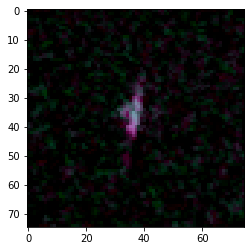

In [4]:
img = X_train[110]
label = Y_train[110]
plt.imshow(img)
labels=['Ship','Iceberg']
print('Label =', labels[int(label)])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label = Ship


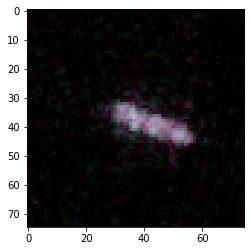

In [5]:
img = X_train[100]
label = Y_train[100]
plt.imshow(img)
labels=['Ship','Iceberg']
print('Label =', labels[int(label)])
plt.show()

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
left_input = tf.keras.layers.Input(shape=(75,75,3)) # Shape of +ve Input image 
right_input = tf.keras.layers.Input(shape=(75,75,3)) # Shape of -ve Input image

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [0]:
base_network = tf.keras.models.Sequential()
#base_network.add(tf.keras.layers.Input(shape=()))
base_network.add(tf.keras.layers.Conv2D(filters=16,kernel_size=3,padding='valid',activation='relu'))
base_network.add(tf.keras.layers.BatchNormalization())

base_network.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='valid',activation='relu'))
base_network.add(tf.keras.layers.BatchNormalization())

base_network.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='valid',activation='relu'))
base_network.add(tf.keras.layers.BatchNormalization())

base_network.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='valid',activation='relu'))
#base_network.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
base_network.add(tf.keras.layers.BatchNormalization())

base_network.add(tf.keras.layers.Flatten())

base_network.add(tf.keras.layers.Dense(units=1024,activation='relu'))
base_network.add(tf.keras.layers.Dropout(rate=0.3))
base_network.add(tf.keras.layers.BatchNormalization())
base_network.add(tf.keras.layers.Dense(units=512,activation='relu'))
base_network.add(tf.keras.layers.Dropout(rate=0.3))
base_network.add(tf.keras.layers.BatchNormalization())
base_network.add(tf.keras.layers.Dense(units=128,activation='relu'))

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
def euclidean_distance(vects):
  '''Compute Euclidean Distance between two vectors'''
  x, y = vects
  return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):

  shape1, shape2 = shapes
  return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):

  margin = 1
  return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
processed_left = base_network(left_input)
processed_right = base_network(right_input)
L1_layer = Lambda(lambda tensor: K.abs(tensor[0]-tensor[1]))
#distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_left, processed_right])
distance = L1_layer([processed_left, processed_right])
prediction = tf.keras.layers.Dense(1,activation='sigmoid')(distance)
model = tf.keras.models.Model([left_input, right_input], prediction)
#model = Model(input=[left_input, right_input], output=distance)

# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])

# Show the Summary of your Siamese Network

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          294849952   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           sequential[2][0]             

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets)).astype('float32')

In [14]:
test_targets.dtype

dtype('float32')

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [15]:
results = model.fit([left_input,right_input],targets,
                    epochs = 100,
                    batch_size=32,validation_data=([test_left,test_right],test_targets)
                    )
                    

Train on 5000 samples, validate on 3113 samples
Epoch 1/100
5000/5000 [==============================] - 27s 5ms/sample - loss: 0.8151 - accuracy: 0.5518 - val_loss: 0.6892 - val_accuracy: 0.5390
Epoch 2/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.6026 - accuracy: 0.6772 - val_loss: 0.5883 - val_accuracy: 0.7212
Epoch 3/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.3852 - accuracy: 0.8312 - val_loss: 0.5583 - val_accuracy: 0.7327
Epoch 4/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.1775 - accuracy: 0.9424 - val_loss: 0.5505 - val_accuracy: 0.7739
Epoch 5/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.0619 - accuracy: 0.9916 - val_loss: 0.5969 - val_accuracy: 0.8008
Epoch 6/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.0256 - accuracy: 0.9976 - val_loss: 0.8615 - val_accuracy: 0.7658
Epoch 7/100
5000/5000 [==============================] - 22s 4ms

KeyboardInterrupt: ignored